In [1]:
import os
os.environ["SDSS_LOCAL_SAS_MIRROR"]="/data/jdli/sdss/"
os.environ["RESULTS_VERS"]="dr17"
os.environ["GAIA_TOOLS_DATA"]="/data/jdli/gaia/"

%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

from astropy.table import Table, join
from astropy.io import fits
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2


%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# import matplotlib.font_manager
# from IPython.core.display import HTML

# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [3]:
cat = Table.read(os.environ["SDSS_LOCAL_SAS_MIRROR"]+"/dr17/ap17_gdr3_tr.fits")

names = [name for name in cat.colnames if len(cat[name].shape)<=1]
df_raw = cat[names].to_pandas()
df_raw.columns

Index(['APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC', 'GLON',
       'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG',
       'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC',
       'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR', 'VSINI', 'source_id', 'visibility_periods_used', 'ruwe'],
      dtype='ob

In [4]:
data_dir = "/data/jdli/gaia/"

data_cont = np.load(data_dir+"ap17_wise_xpcont_cut.npy", allow_pickle=True).item()
data_cont.keys()


dict_keys(['bp_coef', 'rp_coef', 'e_bp_coef', 'e_rp_coef', 'df', 'norm_bp_coef', 'norm_rp_coef', 'lgnorm_bp_andrae', 'lgnorm_rp_andrae'])

In [ ]:
# np.save(data_dir+"ap17_wise_xpcont_cut.npy", data_cont)

In [44]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/jdli/")

import torch
from torch.utils.data import DataLoader
from transpec.model import Spec2label, Spec2HRd, Spec2HRd_err
from transpec.data import GaiaXP_55coefs_alpha, GaiaXP_allcoefs_5label_cont_norm
from matplotlib.colors import LogNorm
import cmasher as cmr

cmap = cmr.dusk


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data_dir = "/data/jdli/gaia/"
tr_file = "ap17_wise_xpcont_cut.npy"


device = torch.device('cuda:0')


gdata  = GaiaXP_55coefs_alpha(data_dir+tr_file, part_train=False, device=device)
gdata_loader = DataLoader(gdata, batch_size=1024)

print(len(gdata))
print(gdata[0]['x'].size(), gdata[0]['y'].size())

81309
torch.Size([1, 113]) torch.Size([1])


In [21]:
!ls /data/jdli/gaia/model/1203_alpha/A/

model_dir =  "/data/jdli/gaia/model/1203_alpha/A/"

model_name = "sp2_alpha_mse_A_ep100.pt"

INPUT_LEN = 55*2+3

model = Spec2label(
        n_encoder_inputs=INPUT_LEN,
        n_outputs=1, channels=512, n_heads=8, n_layers=8,
    attn=True,
    ).to(device)

# model = Spec2HRd(
#     n_encoder_inputs=INPUT_LEN, n_decoder_inputs=INPUT_LEN+2,
#     n_outputs=2, channels=512, n_heads=8, n_layers=8,
# ).to(device)

model.load_state_dict(torch.load(model_dir+model_name))

<All keys matched successfully>

In [8]:
from tqdm import tqdm

def predict_4d(data_loader, model1, model2):
    
    out_lst, y_lst = np.array([]), np.array([])
    id_lst = []
    attn_lst1, attn_lst2 = np.array([]), np.array([])

    with torch.no_grad():
        for data in tqdm(data_loader):

            output1 = model1(data['x'])
            output2 = model2(torch.concat((data['x'],output1.view(-1, 1, 2)), dim=2),)
            out_lst = np.append(out_lst, torch.concat((output1, output2), dim=1).cpu().numpy())
            y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            
            # attn_lst1 = np.append(attn_lst1, attn1.cpu().numpy())
            # attn_lst2 = np.append(attn_lst2, attn2.cpu().numpy())
            
            id_batch =  list(np.int64(data['id']))
            
            del output1, output2, data
            
            for idl in id_batch:
                id_lst.append(idl)

    out_lst, y_lst = np.array(out_lst).reshape(-1,4), np.array(y_lst).reshape(-1,4)
    # attn_lst1 = attn_lst1.reshape(-1, )
    # return out_lst, y_lst, id_lst
    return {'pred':out_lst, 'true':y_lst, 'id':id_lst}

def predict(data_loader, model):
    
    out_lst, y_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            
            output = model(data['x'])
            # output, attn = model(data['x'])
            out_lst = np.append(out_lst, output.cpu().numpy())
            y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)
    out_lst, y_lst = np.array(out_lst).reshape(-1,5), np.array(y_lst).reshape(-1,5)
    return {'pred':out_lst, 'true':y_lst, 'id':id_lst}

def predict_err(data_loader, model):
    
    out_lst, y_lst = np.array([]), np.array([])
    out_err_lst = np.array([])
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            
            output = model(data['x']).view(-1,10)
            # output, attn = model(data['x'])
            out_lst = np.append(out_lst, output[:,:5].cpu().numpy())
            out_err_lst = np.append(out_err_lst, output[:,5:].cpu().numpy())
            y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)
    out_lst, y_lst = np.array(out_lst).reshape(-1,5), np.array(y_lst).reshape(-1,5)
    out_err_lst = np.array(out_err_lst).reshape(-1,5)
    return {'pred':out_lst, 'e_pred':out_err_lst, 'true':y_lst, 'id':id_lst}


def predict_one_label(data_loader, model):
    out_lst, y_lst = np.array([]), np.array([])
    attn_all = []
    id_lst = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            
            output, attn = model(data['x'])
            # output, attn = model(data['x'])
            out_lst = np.append(out_lst, output.cpu().numpy())
            y_lst   = np.append(y_lst, data['y'].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            attn_all.append([a.cpu().numpy().reshape(-1) for a in attn])
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)
                
    out_lst, y_lst = np.array(out_lst).reshape(-1), np.array(y_lst).reshape(-1)
    return {'pred':out_lst, 'true':y_lst, 'id':id_lst, 'attn':attn_all}
    
    
    
# data_infer = predict_4d(gdata_loader, model_tefflogg, model_mohaom)
# data_infer = predict_err(gdata_loader, model)
# data_infer = predict(gdata_loader, model)


In [97]:
# norm = np.array([1e-2, 5., 10., 50.])
norm = np.array([1e-2, 5., 15., 10., 50.])

df_result = pd.DataFrame(
    {'source_id':np.array([np.int64(i) for i in data_infer['id']]),
    'teff_trans':np.array(data_infer['pred'][:,0])/norm[0],
    'logg_trans':np.array(data_infer['pred'][:,1])/norm[1],
     'prlx_trans':np.array(data_infer['pred'][:,2])/norm[2],
     'moh_trans':np.array(data_infer['pred'][:,3])/norm[3],
     'aom_trans':np.array(data_infer['pred'][:,4])/norm[4],
    #  'e_teff_trans':np.array(data_infer['e_pred'][:,0])/norm[0],
    # 'e_logg_trans':np.array(data_infer['e_pred'][:,1])/norm[1],
    #  'e_prlx_trans':np.array(data_infer['e_pred'][:,2])/norm[2],
    #  'e_moh_trans':np.array(data_infer['e_pred'][:,3])/norm[3],
    #  'e_aom_trans':np.array(data_infer['e_pred'][:,4])/norm[4],
    }
)
df_result["source_id"] = pd.to_numeric(df_result["source_id"])
print(df_result.shape)

df_result = df_result.merge(df_raw, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))
print(df_result.shape, df_result.columns)


df_result = df_result.merge(data_cont['df'][['source_id', 'snr_bp', 'snr_rp']], on="source_id")
df_result.to_csv(data_dir + "APtransXP_1125_5labelnorm_55coefs.csv", index=False)


(81309, 6)
(81309, 65) Index(['source_id', 'teff_trans', 'logg_trans', 'prlx_trans', 'moh_trans',
       'aom_trans', 'APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC',
       'GLON', 'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG',
       'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC',
       'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_E

# many plots

In [17]:
df55 = pd.read_csv(data_dir+"APtransXP_1129_5lerrs.csv")


df55 = df55.merge(df_raw, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))
print(df55.shape, df55.columns)


df55 = df55.merge(data_cont['df'][['source_id', 'snr_bp', 'snr_rp']], on="source_id")
df55.to_csv(data_dir + "APtransXP_1125_5labelnorm_55coefs.csv", index=False)


print(df55.shape, df55.columns)

df11 = pd.read_csv(data_dir+"APtransXP_1120.csv")
print(df11.shape)

(81309, 70) Index(['source_id', 'teff_trans', 'e_teff_trans', 'logg_trans', 'e_logg_trans',
       'prlx_trans', 'e_prlx_trans', 'moh_trans', 'e_moh_trans', 'aom_trans',
       'e_aom_trans', 'APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC',
       'GLON', 'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG',
       'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC',
       'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', '

In [141]:
# df_result['snr_bp'].plot(kind='hist')
# df_result['snr_rp'].plot(kind='hist')

snr_bp_grids = np.arange(0, 700+100, 100)
snr_rp_grids = np.arange(0, 2000+200, 200)


df_result = df_result.assign(
    snr_bp_bin=pd.cut(df_result['snr_bp'], bins=snr_bp_grids),
    snr_rp_bin=pd.cut(df_result['snr_rp'], bins=snr_rp_grids),
)



In [142]:
from astropy.stats import bootstrap

boot_stat = lambda x: (np.percentile(x, 14), np.percentile(x, 50), np.percentile(x, 86))

def rmse(res):
    return np.sqrt(np.mean(res**2))



In [151]:
pred_names = ['teff_trans', 'logg_trans', 'prlx_trans', 'moh_trans', 'aom_trans']
true_names = ['TEFF', 'LOGG', 'GAIAEDR3_PARALLAX', 'M_H', 'ALPHA_M']
e_true_names = ['TEFF_ERR', 'LOGG_ERR', 'GAIAEDR3_PARALLAX_ERROR', 'M_H_ERR', 'ALPHA_M_ERR']
n_pars = len(pred_names)
n_boots = 10

chi_arr_bp = np.zeros([n_boots, 3, len(snr_bp_grids)-1, len(pred_names)])
chi_arr_rp = np.zeros([n_boots, 3, len(snr_rp_grids)-1, len(pred_names)])
rmse_bp = np.zeros([n_boots, len(snr_bp_grids)-1, len(pred_names)])
rmse_rp = np.zeros([n_boots, len(snr_rp_grids)-1, len(pred_names)])

for i, (gn, group) in enumerate(df_result.groupby(['snr_bp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        group_boot = bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])/group[e_true_names[j]]),
                               n_boots, bootfunc=boot_stat)
        chi_arr_bp[:,:,i,j] = group_boot
        rmse_bp[:,i,j] =  bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])),
                               n_boots, bootfunc=rmse)
        
        
for i, (gn, group) in enumerate(df_result.groupby(['snr_rp_bin'])):
    print(len(group))
    
    for j in range(n_pars):
        group_boot = bootstrap(np.array((group[pred_names[j]]-group[true_names[j]])/group[e_true_names[j]]),
                               n_boots, bootfunc=boot_stat)
        chi_arr_rp[:,:,i,j] = group_boot
        rmse_rp[:,i,j] =  bootstrap(np.array(group[pred_names[j]]-group[true_names[j]]),
                               n_boots, bootfunc=rmse)


2081
5285
11068
27571
24502
8048
2129
1330
5282
12081
18433
21432
15100
5375
1571
495
150


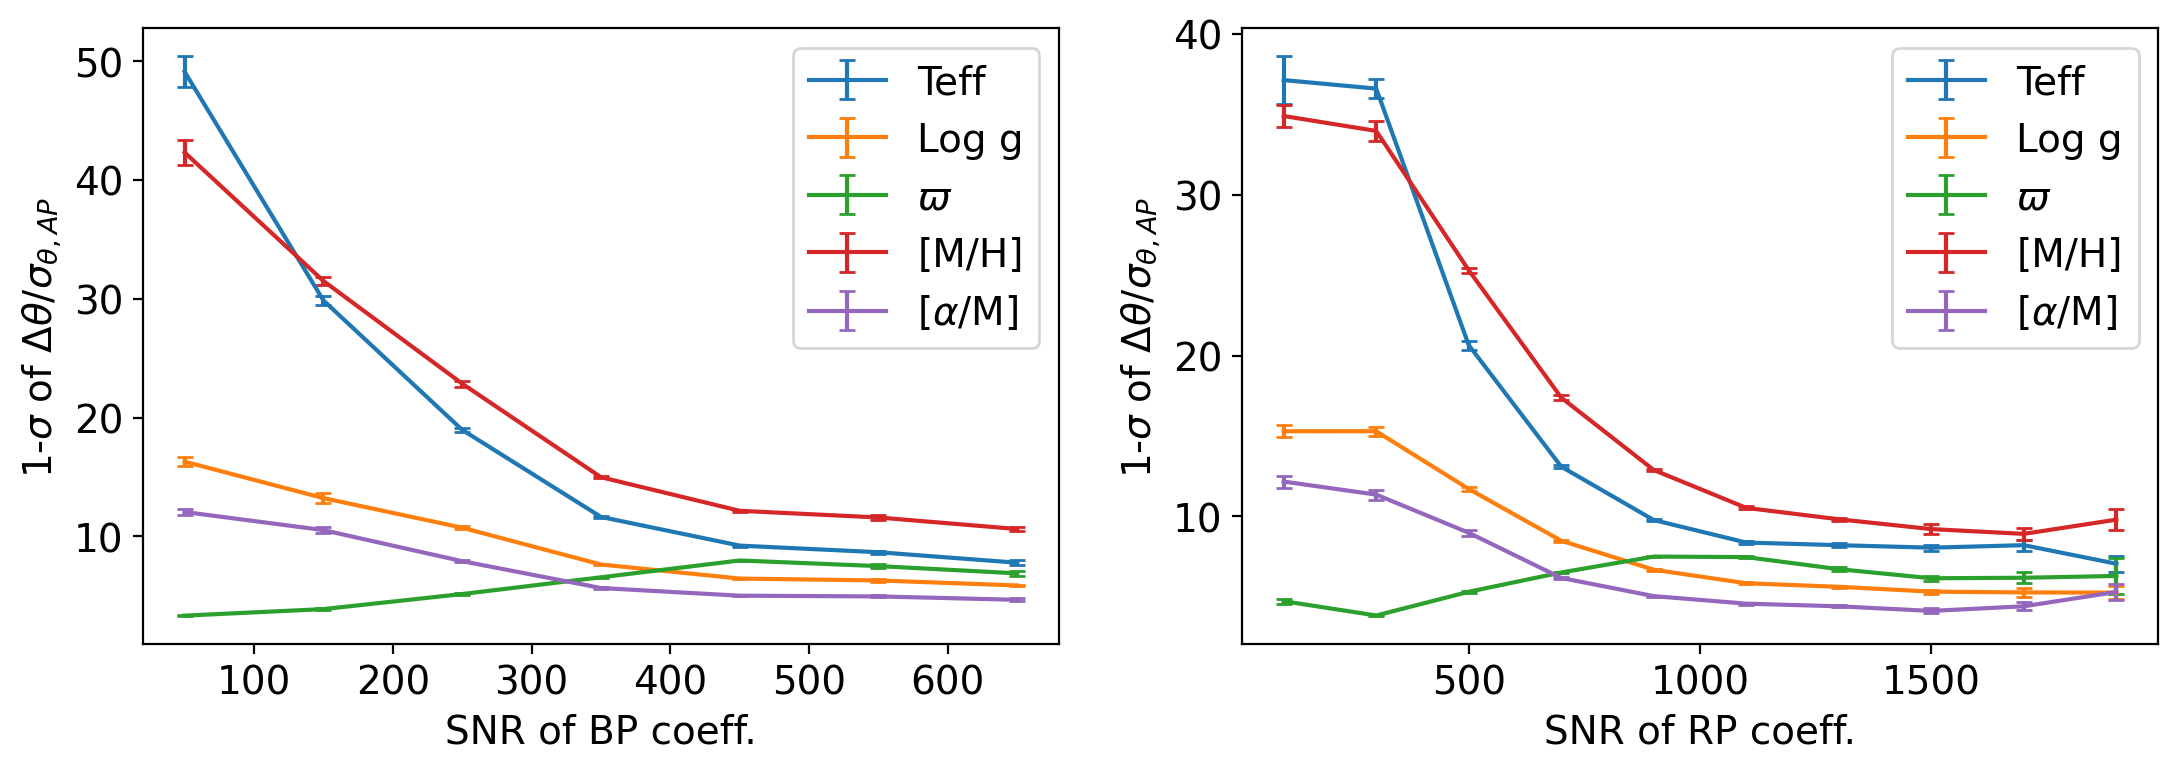

In [175]:
labels = ['Teff', 'Log g', r'$\varpi$', '[M/H]', r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5


fig, axs = plt.subplots(1,2, figsize=(13,4))
ax1, ax2 = axs.ravel()

for i in range(len(labels)):
    if i<10:
        ax1.errorbar(
            snr_bp_mids, 
            # np.mean(rmse_bp[:,:,i], axis=0), 
            # np.std(rmse_bp[:,:,i], axis=0), label=labels[i]
            0.5*np.mean(chi_arr_bp[:,2,:,i]-chi_arr_bp[:,0,:,i], axis=0), 
             0.5*np.std(chi_arr_bp[:,2,:,i]-chi_arr_bp[:,0,:,i], axis=0), 
            label=labels[i], fmt='-', capsize=3
        )
        ax1.legend();
        ax1.set_xlabel("SNR of BP coeff.");
        ax1.set_ylabel(r"1-$\sigma$ of $\Delta \theta / \sigma_{\theta, AP}}$");
        
        ax2.errorbar(
            snr_rp_mids, 
            # np.mean(rmse_rp[:,:,i], axis=0), 
            # np.std(rmse_rp[:,:,i], axis=0), 
             0.5*np.mean(chi_arr_rp[:,2,:,i]-chi_arr_rp[:,0,:,i], axis=0), 
             0.5*np.std(chi_arr_rp[:,2,:,i]-chi_arr_rp[:,0,:,i], axis=0), 
            label=labels[i], fmt='-', capsize=3
        )
        ax2.legend();
        ax2.set_xlabel("SNR of RP coeff.");
        ax2.set_ylabel(r"1-$\sigma$ of $\Delta \theta / \sigma_{\theta, AP}$");

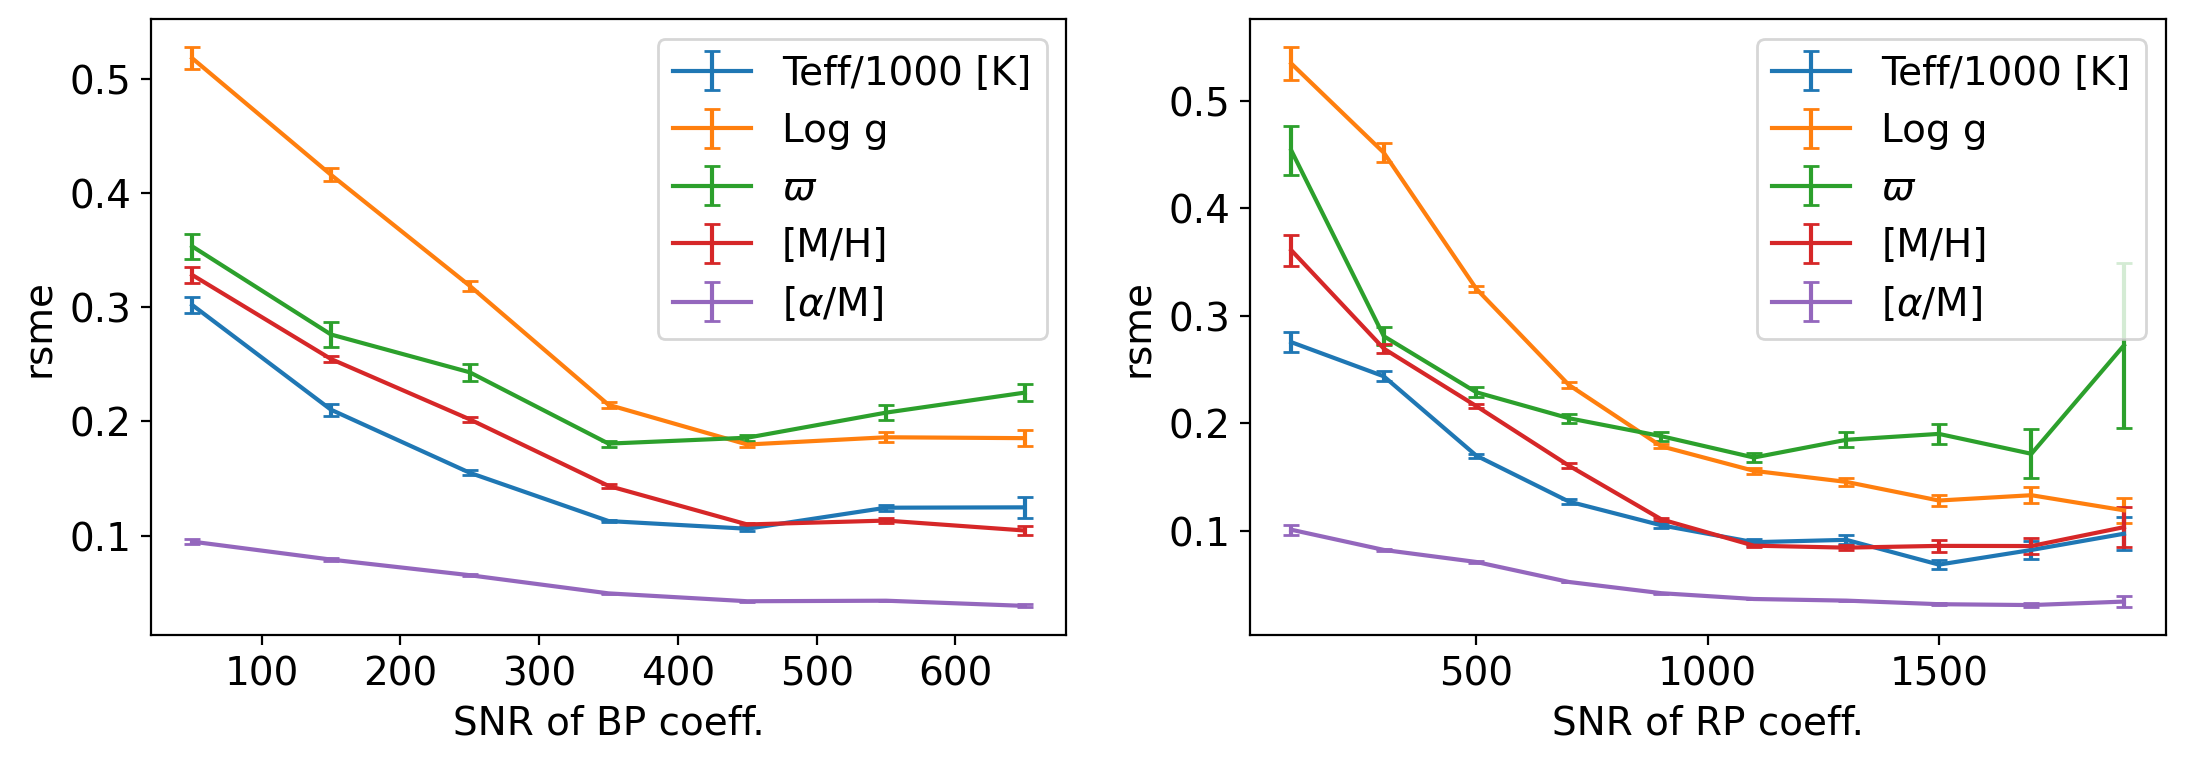

In [174]:
labels = ['Teff', 'Log g', r'$\varpi$', '[M/H]', r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5


fig, axs = plt.subplots(1,2, figsize=(13,4))
ax1, ax2 = axs.ravel()

for i in range(len(labels)):
    if i==0:
        ax1.errorbar(
            snr_bp_mids, 
            1e-3*np.mean(rmse_bp[:,:,i], axis=0), 1e-3*np.std(rmse_bp[:,:,i], axis=0),
            label="Teff/1000 [K]", fmt='-', capsize=3
        )
        ax2.errorbar(
            snr_rp_mids, 
            1e-3*np.mean(rmse_rp[:,:,i], axis=0), 1e-3*np.std(rmse_rp[:,:,i], axis=0), 
            label="Teff/1000 [K]", fmt='-', capsize=3
    )
        
    elif i>0:
        ax1.errorbar(
            snr_bp_mids, 
            np.mean(rmse_bp[:,:,i], axis=0), np.std(rmse_bp[:,:,i], axis=0),
            label=labels[i], fmt='-', capsize=3
        )
        ax2.errorbar(
        snr_rp_mids, 
        np.mean(rmse_rp[:,:,i], axis=0), np.std(rmse_rp[:,:,i], axis=0), 
        label=labels[i], fmt='-', capsize=3
    )
        
    ax1.legend();
    ax1.set_xlabel("SNR of BP coeff.");
    ax1.set_ylabel(r"rsme");

    ax2.legend();
    ax2.set_xlabel("SNR of RP coeff.");
    ax2.set_ylabel(r"rsme")

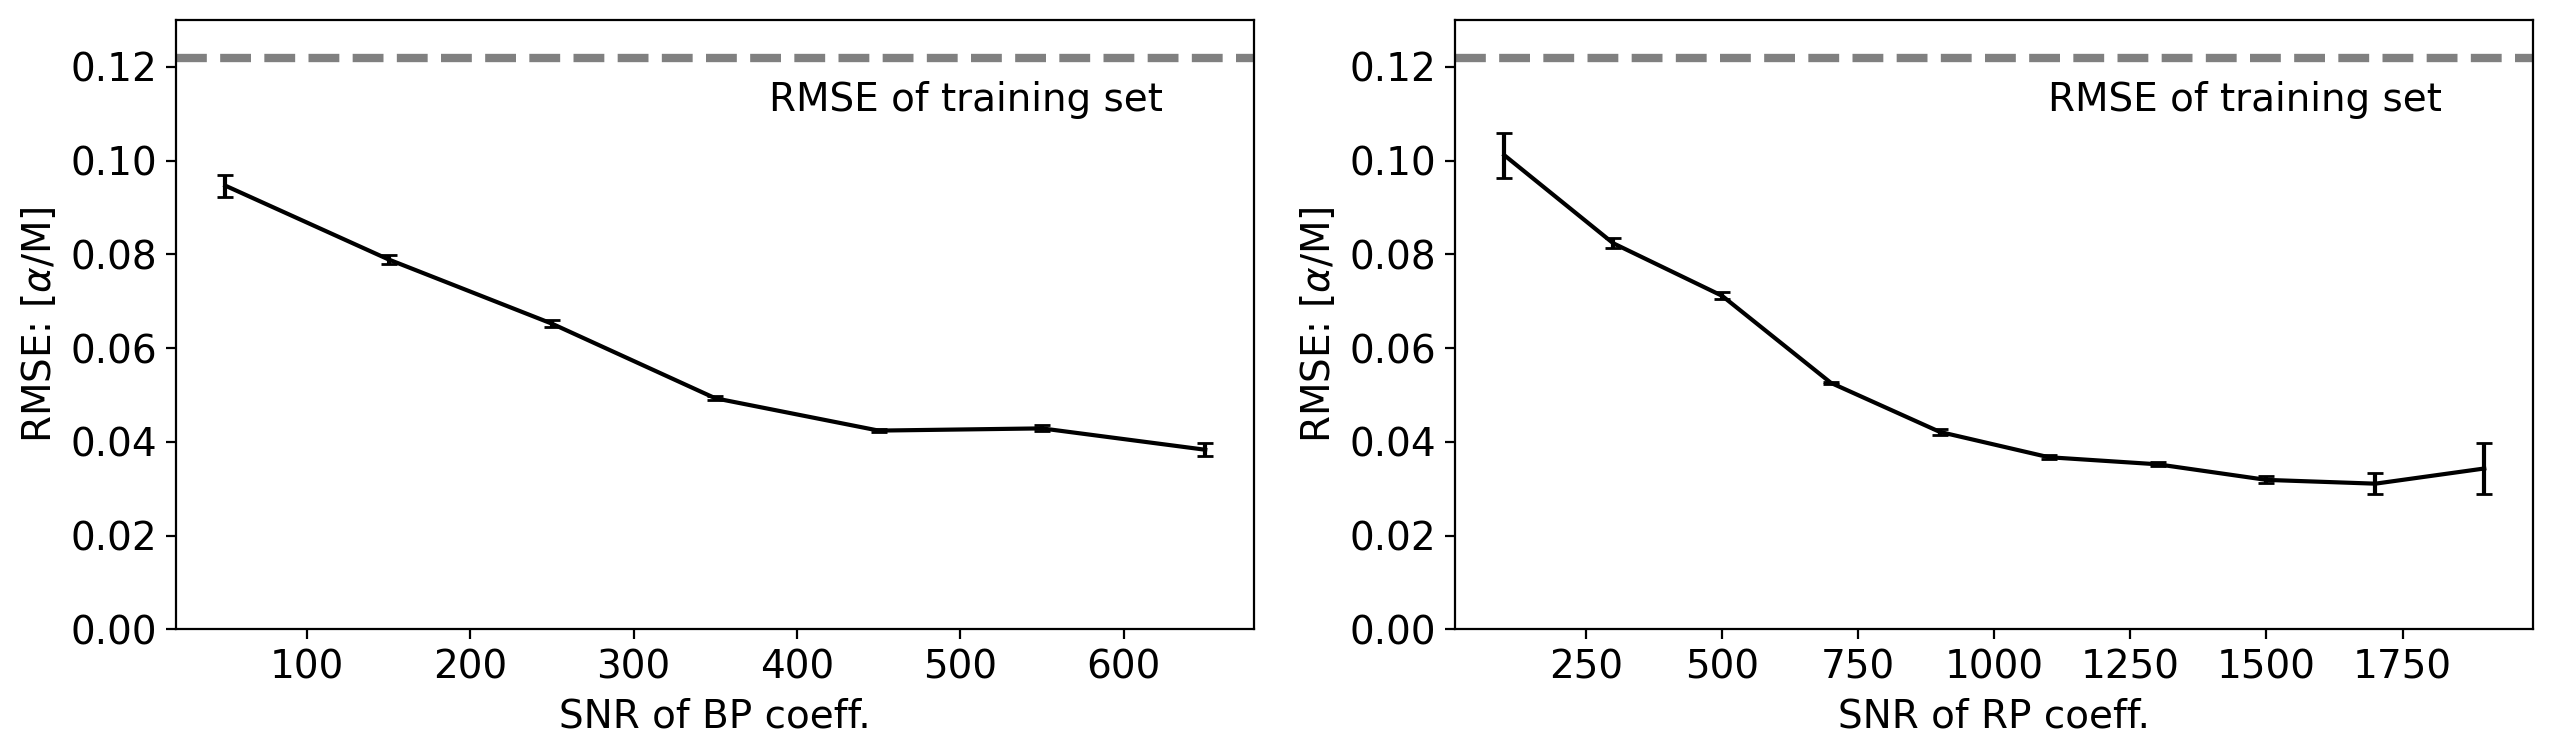

In [211]:
labels = [r'[$\alpha$/M]']

snr_bp_mids = snr_bp_grids[:-1]+np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1]+np.diff(snr_rp_grids)*0.5


fig, axs = plt.subplots(1,2, figsize=(13,4))
ax1, ax2 = axs.ravel()

i=0
ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_bp[:,:,4], axis=0), np.std(rmse_bp[:,:,4], axis=0),
     fmt='-', capsize=3, c='k'
)
ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_rp[:,:,4], axis=0), np.std(rmse_rp[:,:,4], axis=0), 
    fmt='-', capsize=3, c='k'
)
        

ax1.set_xlabel("SNR of BP coeff.");
ax1.set_ylabel(r"RMSE: [$\alpha$/M]");

ax1.axhline(y=rmse(df_result['aom_trans']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")
ax2.axhline(y=rmse(df_result['aom_trans']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")

ax2.set_ylabel(r"RMSE: [$\alpha$/M]");
ax2.set_xlabel("SNR of RP coeff.");

ax1.text(0.55, 0.85, 'RMSE of training set', transform=ax1.transAxes)
ax2.text(0.55, 0.85, 'RMSE of training set', transform=ax2.transAxes)


ax1.set_ylim([0, 0.13]);
ax2.set_ylim([0, 0.13]);
plt.tight_layout()
fig.savefig("../fig/rsme_alpha.png")

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(5*5, 5*1))

pred_names = ['teff_trans', 'logg_trans', 'prlx_trans', 'moh_trans', 'aom_trans']
true_names = ['TEFF', 'LOGG', 'GAIAEDR3_PARALLAX', 'M_H', 'ALPHA_M']
xranges = [[3300, 6500], [-0.1, 5], [-0.1, 2.], [-2.2, 0.5], [-0.3, 0.5]]
yranges = [[-800, 800],  [-1.2, 1.2], [-1., 1.], [-0.6, 0.6], [-0.2, 0.2]]
xlabels = ['Teff: APO [K]', 'Log g: APO', r'$\varpi$: APO [mas]', 
           '[M/H]: APO', r"[$\alpha$/M] : APO"]
ylabels = ['Teff: GXP [K]', 'Log g: GXP', r'$\varpi$: GXP [mas]', 
           '[M/H]: GXP', r"[$\alpha$/M] : GXP"]
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta \varpi$',
            r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/M]']

for i in range(len(axs)):
    ax1, ax2 = draw_compare(
        axs[i], df_result[pred_names[i]], df_result[true_names[i]],
        xrange=xranges[i], bins=100
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i])


plt.tight_layout()

In [ ]:
group = df_result[df_result['GAIAEDR3_PHOT_G_MEAN_MAG']<12.]
print(group.shape)


fig, axs = plt.subplots(1,5, figsize=(5*5, 5*1))

for i in range(len(axs)):
    ax1, ax2 = draw_compare(
        axs[i], group[pred_names[i]], group[true_names[i]],
        xrange=xranges[i], bins=100
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    # ax1.set_title("Gmag < 12 mag")
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i])

plt.tight_layout()

In [252]:
# fig.savefig("../fig/compare4d.pdf")

In [ ]:
group = df_result[df_result['GAIAEDR3_PHOT_G_MEAN_MAG']>12.]
print(group.shape)


fig, axs = plt.subplots(1,5, figsize=(5*5, 5*1))

for i in range(len(axs)):
    ax1, ax2 = draw_compare(
        axs[i], group[pred_names[i]], group[true_names[i]],
        xrange=xranges[i]
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax1.set_title("Gmag > 12 mag")
    
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i])


plt.tight_layout()

In [243]:
def draw_moh_aom(ax, moh, aom, bins=100):
    
    _, _, _, img = ax.hist2d(
        moh, aom,
        bins=bins, norm=LogNorm(), 
        cmap=cmap
    )
    clb1 = fig.colorbar(img, ax=ax,);
    clb1.set_label('Counts', labelpad=-20, y=1.1, rotation=0)

    ax.set_xlabel("[M/H] : GXP");
    ax.set_ylabel(r"[$\alpha$/M] : GXP");
    ax.set_xlim([-2.5, 0.5]);
    ax.set_ylim([-0.3, 0.5]);
    return ax


def plot_kiel(ax, teff, logg, moh, bins=100):
    
    teff_bins = np.linspace(3300, 6500, 50)
    logg_bins = np.linspace(0, 5, 50)

    img = ax.scatter(teff, logg, cmap='coolwarm', s=3, c=moh, vmin=-1, vmax=0, alpha=0.5)
    
    ax.set_xlim([6500, 3300]);
    ax.set_ylim([5, -0.2]);

    clb = fig.colorbar(img, ax=ax, extend='both');
    clb.set_label(r'[M/H]$_{\rm GXP}$', labelpad=-20, y=1.1, rotation=0, )
    ax.set_xlabel("Teff : GXP");
    ax.set_ylabel("Log g: GXP");
    return ax

In [254]:
BIN = 5

df_result = df_result.assign(
    G_bin = pd.cut(df_result['GAIAEDR3_PHOT_G_MEAN_MAG'], bins=BIN),
    B_bin = pd.cut(df_result['GAIAEDR3_PHOT_BP_MEAN_MAG'], bins=BIN),
    R_bin = pd.cut(df_result['GAIAEDR3_PHOT_RP_MEAN_MAG'], bins=BIN),
)


In [ ]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

fig, axs = plt.subplots(3, BIN, figsize=(5*BIN, 4*3))


for i, (gname, group) in enumerate(df_result.groupby('G_bin')):
    ax1 = draw_moh_aom(
        axs[0,i], group['moh_trans'], group['aom_trans'],
    )
    
    
    ax2 = plot_kiel(
        axs[1,i], group['teff_trans'], group['logg_trans'],
        group['moh_trans'],
    )
    in_ax = inset_axes(ax2, width="30%", height=1., loc=2)
    in_ax.hist(group['GAIAEDR3_PHOT_G_MEAN_MAG'], bins=10, alpha=0.6, color='grey')
    in_ax.set_xlim([8, 16]);
    in_ax.set_yticks([]);
    in_ax.xaxis.set_tick_params(labelsize=10)
    # in_ax.set_xticks([8, 12, 16], fontize=8);
    in_ax.set_xlabel('Gmag', fontsize=10);
    plt.tick_params(top='off', bottom='off', left='off', right='off', 
                    labelleft='off', labelbottom='on')
    
    
    ax3 =  plot_kiel(
        axs[2,i], group['TEFF'], group['LOGG'],
        group['M_H'],
    )

plt.tight_layout()

In [202]:
BIN = 10

df_result = df_result.assign(
    G_bin = pd.cut(df_result['GAIAEDR3_PHOT_G_MEAN_MAG'], bins=BIN),
    B_bin = pd.cut(df_result['GAIAEDR3_PHOT_BP_MEAN_MAG'], bins=BIN),
    R_bin = pd.cut(df_result['GAIAEDR3_PHOT_RP_MEAN_MAG'], bins=BIN),
)

df_result = df_result.assign(
    Delta_teff = df_result['teff_trans']-df_result['TEFF'], 
    Delta_logg =  df_result['logg_trans']-df_result['LOGG'], 
    Delta_moh =  df_result['moh_trans']-df_result['M_H'], 
    Delta_aom =  df_result['aom_trans']-df_result['ALPHA_M'], 
)


# rmse_teff_Gbin = df_result.groupby('G_bin').apply(lambda x: mean_squared_error(x.teff_trans, x.TEFF, squared=False))


In [226]:
# from astropy.coordinates import SkyCoord 


# c1 = SkyCoord(75.51187586, -63.41248894, frame='icrs',unit="deg")  # Units from string
# c2 = SkyCoord("5h2m8.440692256s -63d22m59.979631512s", frame="icrs")


In [ ]:
# group = df[df_result['']>12.]
# GAIAEDR3_PHOT_G_MEAN_MAG

fig, axs = plt.subplots(2,2, figsize=(5*2, 5*2))
titles = ['G > 12 mag, 10 coeff.', 'G > 12 mag, 55 coeff.', 
          'G < 12 mag, 10 coeff.', 'G < 12 mag, 55 coeff.', ]

for i in range(len(axs.ravel())):
    
    if i==0:
        ind = df11['GAIAEDR3_PHOT_G_MEAN_MAG']>12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], df11['ALPHA_M'][ind], df11['aom_trans'][ind],
            xrange=(-0.3,0.5)
        )
        
    elif i==1:
        ind = df11['GAIAEDR3_PHOT_G_MEAN_MAG']<12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], df11['ALPHA_M'][ind], df11['aom_trans'][ind],
            xrange=(-0.3,0.5)
        )
    elif i==2:
        ind = df55['GAIAEDR3_PHOT_G_MEAN_MAG']>12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], df55['ALPHA_M'][ind], df55['aom_trans'][ind],
            xrange=(-0.3,0.5)
        )
    elif i==3:
        ind = df55['GAIAEDR3_PHOT_G_MEAN_MAG']<12
        ax1, ax2 = draw_compare(
            axs.ravel()[i], df55['ALPHA_M'][ind], df55['aom_trans'][ind],
            xrange=(-0.3,0.5)
        )
        
    ax1.set_ylabel(r"[$\alpha$/M] : Gaia XP");
    ax1.set_xticks([]);
    ax1.set_title(titles[i])
    
    ax2.set_xlabel(r"[$\alpha$/M] : APOGEE DR17");
    ax2.set_ylabel(r"$\Delta$ [$\alpha$/M]");
    ax2.set_ylim([-0.3, 0.3])

plt.tight_layout()

In [187]:
fig.savefig("../fig/aom_2x2.png")

# ALPHA abundance trustworthy


In [22]:
data_infer = predict_one_label(gdata_loader, model)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:41<00:00,  1.26s/it]


In [32]:
data_infer['attn'][0][5].shape

(1024,)

In [26]:
norm = 50.

df_result = pd.DataFrame(
    {'source_id':np.array([np.int64(i) for i in data_infer['id']]),
     'aom_trans':np.array(data_infer['pred'])/norm,
    }
)
df_result["source_id"] = pd.to_numeric(df_result["source_id"])
print(df_result.shape)

df_result = df_result.merge(df_raw, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", suffixes=(None, '_y'))
print(df_result.shape, df_result.columns)


df_result = df_result.merge(
    data_cont['df'][
        ['source_id', 'snr_bp', 'snr_bp10', 'snr_bp55', 
         'snr_rp', 'snr_rp10', 'snr_rp55' ]], on="source_id"
)
# df_result.to_csv(data_dir + "APtransXP_1202_aom_55coefs.csv", index=False)
print(df_result.columns)

(81309, 2)
(81309, 61) Index(['source_id', 'aom_trans', 'APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID',
       'RA', 'DEC', 'GLON', 'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR',
       'AK_TARG', 'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV',
       'STARFLAG', 'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG',
       'VSCATTER', 'VERR', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX',
       'GAIAEDR3_PARALLAX_ERROR', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR',
       'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR', 'VSINI', 'source_id_y', 

In [9]:
df_result = pd.read_csv(data_dir + "APtransXP_1202_aom_55coefs.csv")
print(df_result.shape)

(81309, 67)


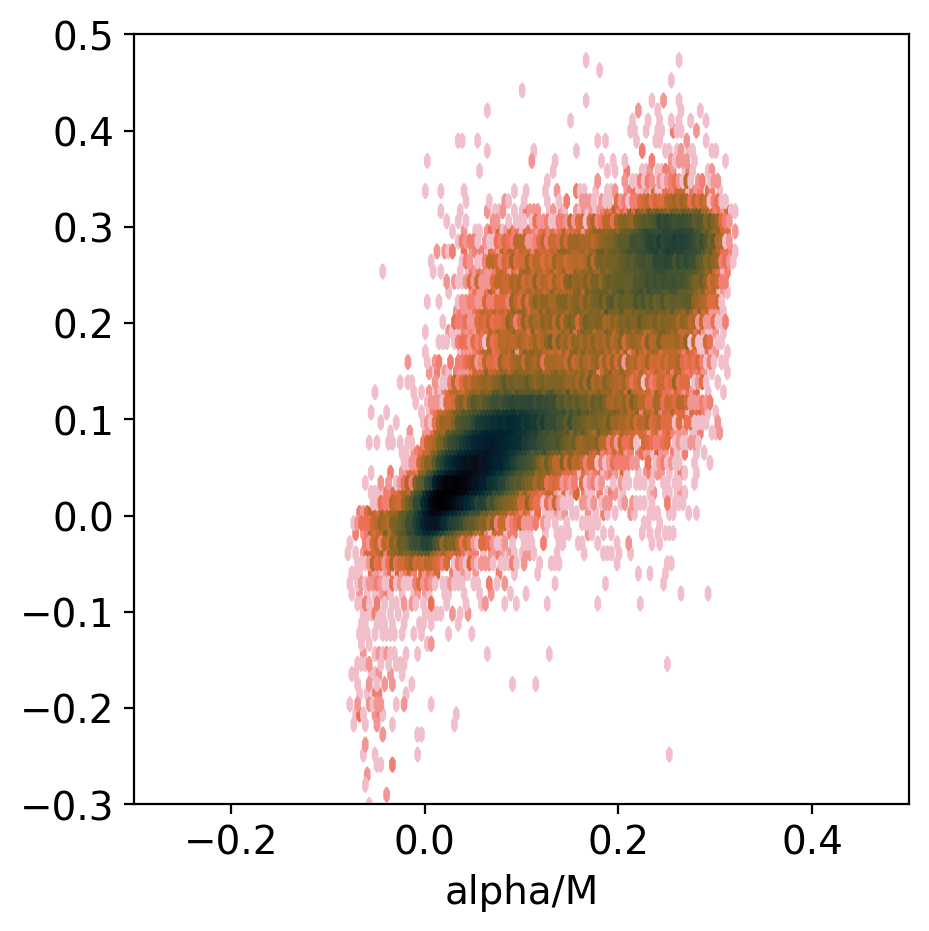

In [27]:
def draw_compare(ax, pred, true, xrange=[-0.3, 0.5], bins=100, cmap='cmr.dusk_r'):
    
    ax.hexbin(true, pred, cmap=cmap, norm=LogNorm())
    ax.set_xlim(xrange)
    ax.set_ylim(xrange)
    return ax

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = draw_compare(ax, df_result['ALPHA_M'], df_result['aom_trans'])
ax.set_xlabel("alpha/M");

In [28]:
from astropy.stats import bootstrap

boot_stat = lambda x: (np.percentile(x, 14), np.percentile(x, 50), np.percentile(x, 86))

def rmse(res):
    return np.sqrt(np.mean(res**2))

def mae(res):
    return np.median(np.abs(res))


print(rmse(df_result['ALPHA_M']-df_result['aom_trans']))
print(mae(df_result['ALPHA_M']-df_result['aom_trans']))

0.04691096235899539
0.02074412733316422


In [29]:
labels = [r'[$\alpha$/M]']

snr_bp_grids = np.arange(0, 700+100, 75)
snr_rp_grids = np.arange(0, 2000+200, 200)
low_snr_grids = np.linspace(0, 5, 11)


df_result = df_result.assign(
    snr_bp_bin  = pd.cut(df_result['snr_bp'],   bins=snr_bp_grids),
    snr_bp10_bin= pd.cut(df_result['snr_bp10'], bins=snr_bp_grids),
    snr_bp55_bin= pd.cut(df_result['snr_bp55'], bins=low_snr_grids),
    snr_rp_bin  = pd.cut(df_result['snr_rp'],   bins=snr_rp_grids),
    snr_rp10_bin= pd.cut(df_result['snr_rp10'], bins=snr_rp_grids),
    snr_rp55_bin= pd.cut(df_result['snr_rp55'], bins=low_snr_grids),
)

snr_bp_mids = snr_bp_grids[:-1] + np.diff(snr_bp_grids)*0.5
snr_rp_mids = snr_rp_grids[:-1] + np.diff(snr_rp_grids)*0.5
low_snr_mids= low_snr_grids[:-1]+ np.diff(low_snr_grids)*0.5

pred_names = "aom_trans"
true_names = "ALPHA_M"
n_boots = 10

# rmse_bp = np.zeros([n_boots, len(snr_bp_grids)-1])
# rmse_rp = np.zeros([n_boots, len(snr_rp_grids)-1])
rmse_arr = np.zeros([6, n_boots, len(snr_bp_mids)])


bin_names = ["snr_bp_bin", "snr_bp10_bin", "snr_bp55_bin", 
            "snr_rp_bin", "snr_rp10_bin", "snr_rp55_bin"]


for j, bin_name in enumerate(bin_names):
    print("bin %s stats."%bin_name)
    
    for i, (gn, group) in enumerate(df_result.groupby([bin_name])):
        print(len(group))
        rmse_arr[j,:,i] =  bootstrap(np.array((group[pred_names]-group[true_names])), n_boots, bootfunc=rmse)
        
    

bin snr_bp_bin stats.
1060
3411
4769
9194
19786
22268
13070
4997
1819
627
bin snr_bp10_bin stats.
413
2004
2774
3553
5039
8641
14145
15713
13251
7903
bin snr_bp55_bin stats.
31
2030
20598
30368
17455
6878
2548
846
307
101
bin snr_rp_bin stats.
1330
5282
12081
18433
21432
15100
5375
1571
495
150
bin snr_rp10_bin stats.
467
1186
2918
4897
7426
9530
11126
12207
12037
9363
bin snr_rp55_bin stats.
59
3479
25625
21649
12548
7220
4289
2667
1569
920


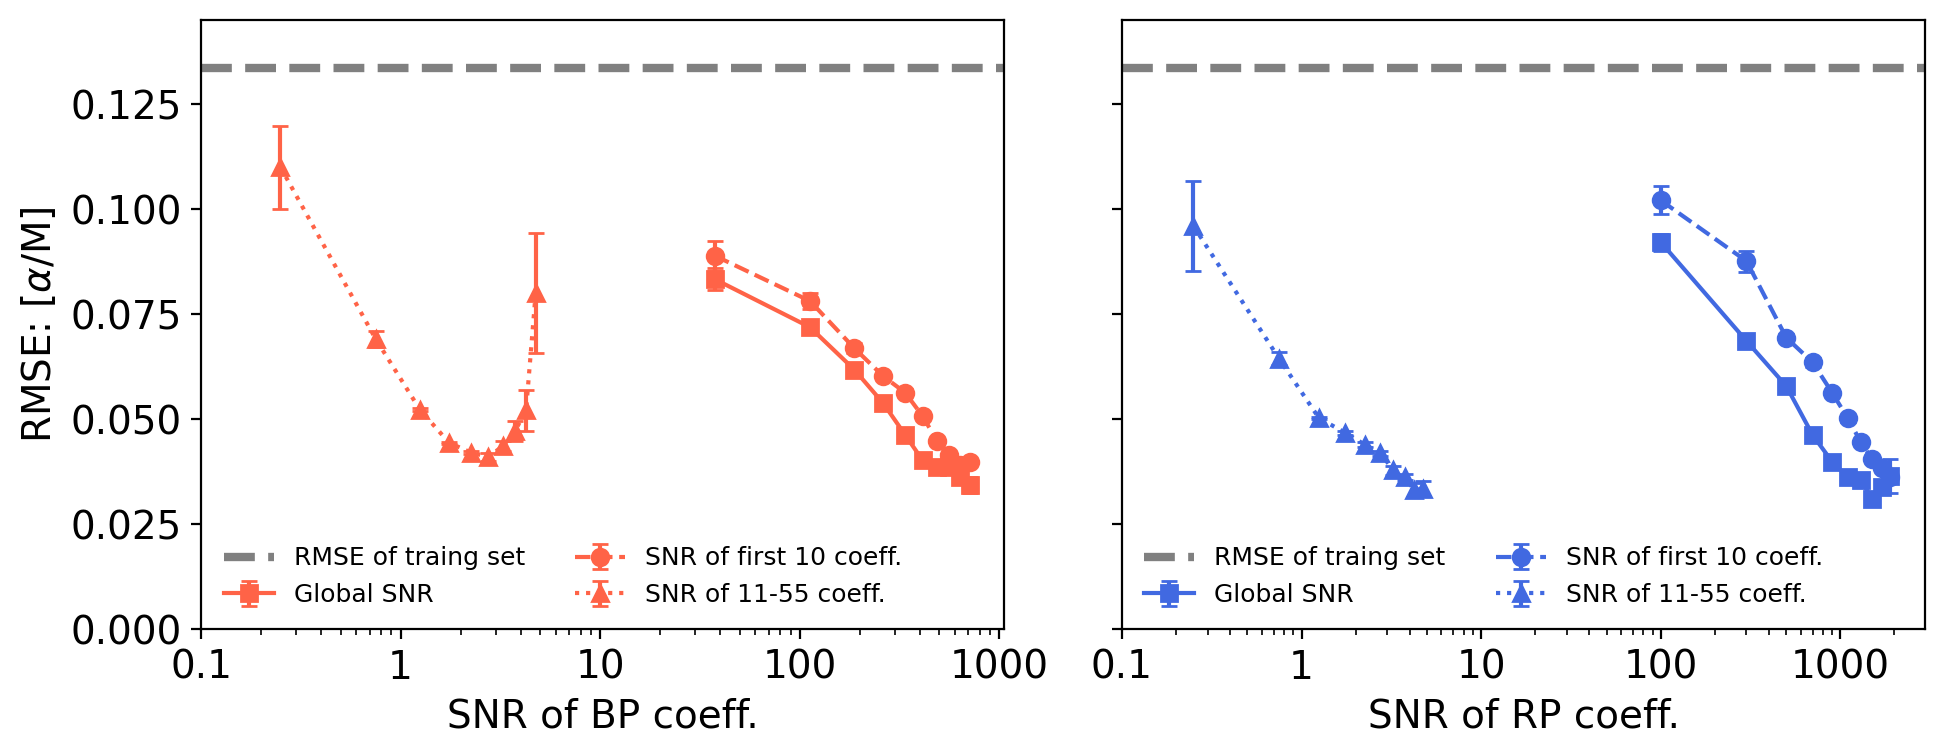

In [30]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax1, ax2 = axs.ravel()


ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_arr[0,:,:], axis=0), np.std(rmse_arr[0,:,:], axis=0),
     fmt='s-', capsize=3, c='tomato', label='Global SNR'
)
ax1.errorbar(
    snr_bp_mids, 
    np.mean(rmse_arr[1,:,:], axis=0), np.std(rmse_arr[1,:,:], axis=0),
     fmt='o--', capsize=3, c='tomato', label='SNR of first 10 coeff.'
)
ax1.errorbar(
    low_snr_mids, 
    np.mean(rmse_arr[2,:,:], axis=0), np.std(rmse_arr[2,:,:], axis=0),
     fmt='^:', capsize=3, c='tomato', label='SNR of 11-55 coeff.'
)
ax1.set_xscale('log')

ax1.set_xlabel("SNR of BP coeff.");
ax1.set_ylabel(r"RMSE: [$\alpha$/M]");
ax1.axhline(y=rmse(df_result['ALPHA_M']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")
ax2.axhline(y=rmse(df_result['ALPHA_M']), lw=3, ls='--', color='grey',
            label="RMSE of traing set")

ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_arr[3,:,:], axis=0), np.std(rmse_arr[3,:,:], axis=0),
     fmt='s-', capsize=3, c='royalblue', label='Global SNR'
)
ax2.errorbar(
    snr_rp_mids, 
    np.mean(rmse_arr[4,:,:], axis=0), np.std(rmse_arr[4,:,:], axis=0),
     fmt='o--', capsize=3, c='royalblue', label='SNR of first 10 coeff.'
)
ax2.errorbar(
    low_snr_mids, 
    np.mean(rmse_arr[5,:,:], axis=0), np.std(rmse_arr[5,:,:], axis=0),
     fmt='^:', capsize=3, c='royalblue', label='SNR of 11-55 coeff.'
)
ax2.set_xlabel("SNR of RP coeff.");
ax2.set_xscale('log')

# ax1.text(0.5, 0.85, 'RMSE of training set', transform=ax1.transAxes)
# ax2.text(0.5, 0.85, 'RMSE of training set', transform=ax2.transAxes)

ax1.set_ylim([0, 0.145]);
ax2.set_ylim([0, 0.145]);


ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticks([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax1.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticks([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);
ax2.set_xticklabels([0.1, 1, 10, 100, 1000]);

ax1.legend(loc=3, fontsize=9, frameon=False, ncol=2);
ax2.legend(loc=3, fontsize=9, frameon=False, ncol=2);

plt.tight_layout()
# fig.savefig("../fig/rsme_alpha.png")